# Lithofacies Classifier

In [ ]:
# ploting, dataframe, and numerical operation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotfunc import lithoplot_data, lithoplot_val, lithoplot_test

# dataset splitting
from sklearn.model_selection import train_test_split

# training
!pip install jcopml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease
from sklearn.metrics import f1_score, classification_report

# evaluation
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_actual_vs_prediction

# feature engineering
from jcopml.feature_importance import mean_score_decrease as msd

## Data Loading

In [ ]:
df = pd.read_csv("litho_train.csv")

df = df.replace([-999.25, df['GR'].max()], np.nan)

df.head()

,Depth,Well,Formation,GR,NPHI,RHOB,DTCO,DTSM,Facies
0,4600.0,P-2,Jamieson Fm,66.4510,13.8882,2.5715,81.8708,NaN,4
1,4600.5,P-2,Jamieson Fm,54.4524,12.1851,2.5604,78.5466,NaN,4
2,4601.0,P-2,Jamieson Fm,51.3234,12.0860,2.5458,81.6343,NaN,4
3,4601.5,P-2,Jamieson Fm,49.2121,11.5609,2.5479,78.2709,NaN,4
4,4602.0,P-2,Jamieson Fm,68.4992,15.9469,2.5307,79.5989,NaN,4


## Data Statistics and Visualization

- Imbalance data

- Classification metrics = f1 score

In [ ]:
df.describe()

,Depth,GR,NPHI,RHOB,DTCO,DTSM,Facies
count,2995.000000,2752.000000,2905.000000,2829.000000,2663.000000,2468.000000,2995.000000
mean,4962.672287,66.165314,20.972374,2.654081,68.878980,121.471750,2.147579
std,216.569096,35.172555,10.996101,0.119257,9.306656,22.403778,1.368699
min,4577.000000,5.377100,2.085300,1.525400,42.793000,69.261800,0.000000
25%,4775.500000,34.857950,11.536800,2.629200,62.438000,103.399550,1.000000
50%,4962.500000,65.585350,20.416900,2.674400,67.129600,117.314650,2.000000
75%,5149.750000,92.777125,27.419500,2.711300,75.134050,136.881475,2.000000
max,5351.000000,171.265700,82.672200,3.157100,179.561400,234.866500,5.000000


In [ ]:
df.Facies.value_counts()

2    1452
1     974
5     495
0      50
3      17
4       7
Name: Facies, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


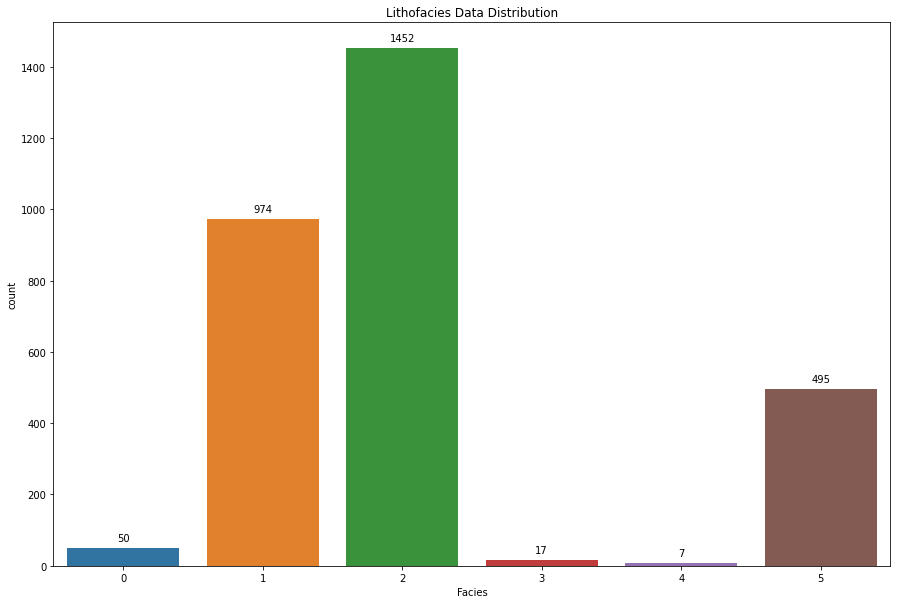

In [ ]:
plt.figure(figsize = (15, 10))

litplot = sns.countplot(df.Facies);

for i in litplot.patches:
    litplot.annotate(format(i.get_height()), (i.get_x() + i.get_width() / 2., i.get_height()), 
                     ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Lithofacies Data Distribution')

plt.savefig('lit_distribution.png')

plt.show()

## Missing Values Checking

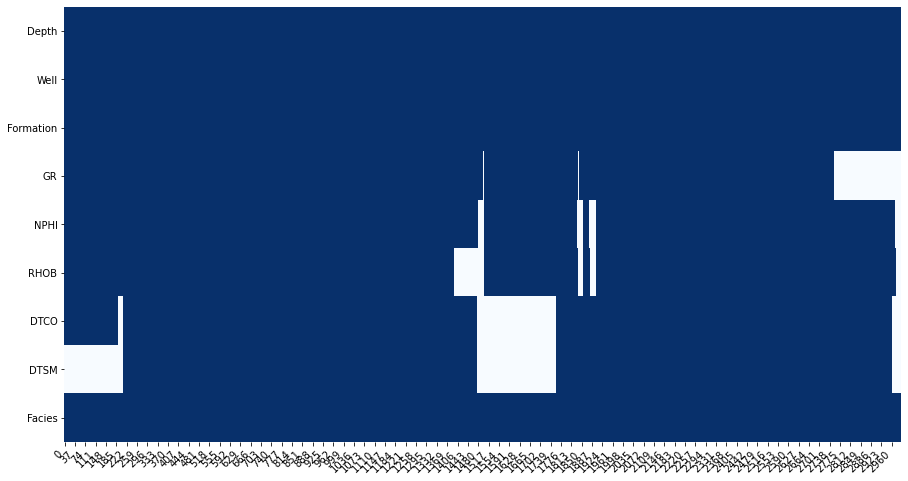

In [ ]:
plot_missing_value(df)

## Training Data Plotting

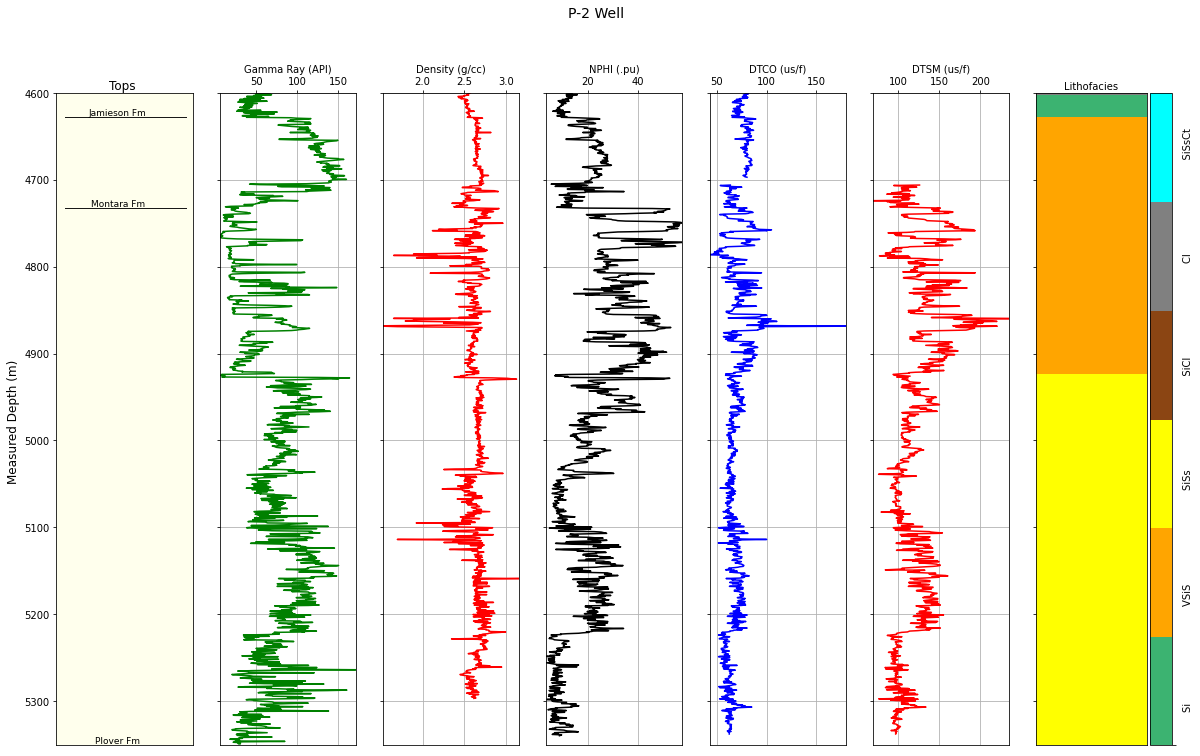

In [ ]:
lithoplot_data(df, 'P-2')

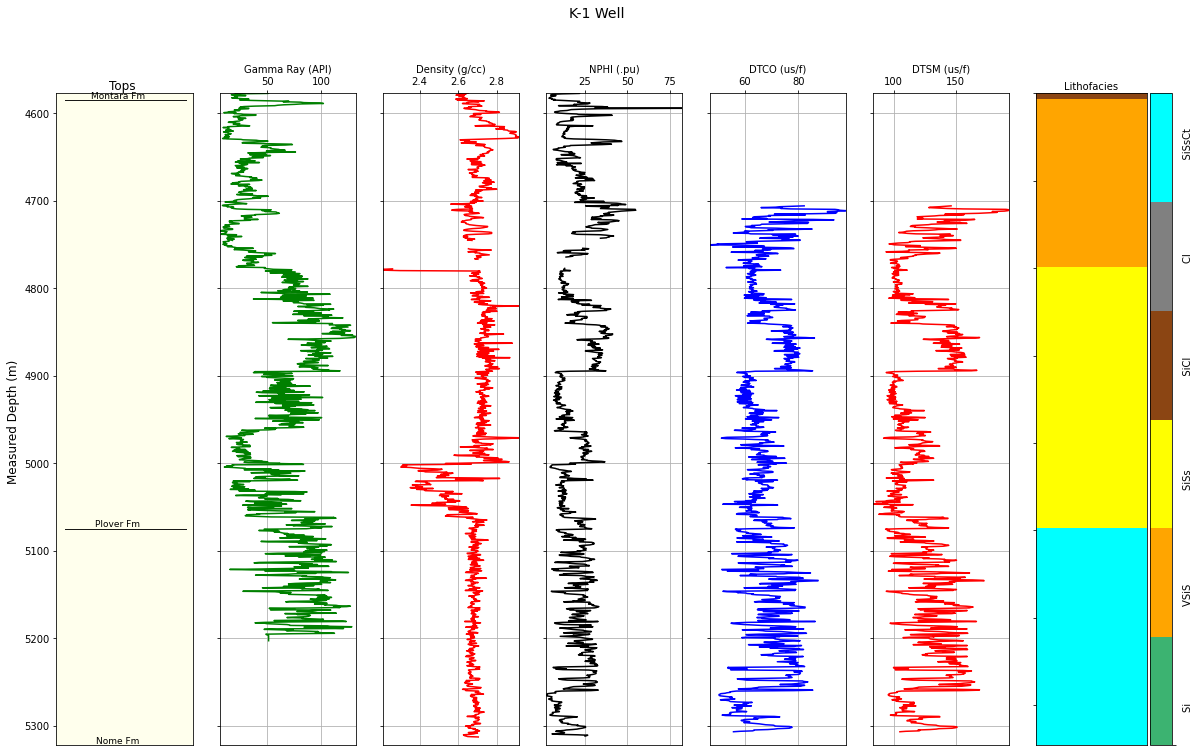

In [ ]:
lithoplot_data(df, 'K-1')

## Dataset Splitting

- Change test size from 0.2 to 0.3 (score max 99% training 87% testing), done

- Change test size from 0.3 to 0.2  again (score max 99% training 88% testing) for final model, done

In [ ]:
df.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM',
       'Facies'],
      dtype='object')

In [ ]:
X = df.drop(columns=['Depth', 'Well', 'Formation', 'Facies'])
y = df.Facies

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2396, 5), (599, 5), (2396,), (599,))

In [ ]:
X.columns

Index(['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

## Training

- Using F1 scoring method (due to imbalance dataset indication), done

- Impute the NaN value using manual numerical_pipeline (train score 99%, test score 91%), done - final

In [ ]:
X_train.columns

Index(['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'], dtype='object')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp

from sklearn.metrics import make_scorer

In [ ]:
gsp.knn_params

{'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
 'algo__p': [1, 1.5, 2],
 'algo__weights': ['uniform', 'distance']}

In [ ]:
# f1 score scorer
f1 = make_scorer(f1_score, average = 'macro')

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(impute= 'mean', scaling= 'standard'), X_train.columns)            
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_params, cv= 5, n_jobs=-1, verbose=1, scoring= f1,
                     return_train_score = True)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 290 tasks      | elapsed:   36.8s



{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'distance'}
0.9994365065578042 0.8196468099707751 0.9113261351776111


[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  1.1min finished


### Tuning Report

- Show the split_train_score (done)

In [ ]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__n_neighbors,param_algo__p,param_algo__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
7,0.009468,0.003848,0.010789,0.000418,3,1,distance,"{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__...",0.820070,0.899896,0.786738,0.692450,0.899080,0.819647,0.077475,1,0.999295,0.999648,0.999648,0.995715,0.999296,0.998720,0.001511
6,0.007575,0.000210,0.030269,0.003992,3,1,uniform,"{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__...",0.819298,0.892305,0.774118,0.680761,0.890563,0.811409,0.079160,2,0.907567,0.867879,0.920948,0.926185,0.913046,0.907125,0.020639
17,0.006762,0.000497,0.008277,0.000234,5,2,distance,"{'algo__n_neighbors': 5, 'algo__p': 2, 'algo__...",0.709465,0.889199,0.815312,0.734857,0.880486,0.805864,0.073399,3,0.999295,0.999648,0.999648,0.999296,0.999296,0.999437,0.000172
9,0.007611,0.000501,0.078070,0.002039,3,1.5,distance,"{'algo__n_neighbors': 3, 'algo__p': 1.5, 'algo...",0.696988,0.901466,0.784414,0.696639,0.881904,0.792282,0.087457,4,0.999295,0.999648,0.999648,0.995715,0.999296,0.998720,0.001511
11,0.006662,0.000376,0.007994,0.000975,3,2,distance,"{'algo__n_neighbors': 3, 'algo__p': 2, 'algo__...",0.698880,0.898678,0.785303,0.685197,0.881381,0.789888,0.088848,5,0.999295,0.999648,0.999648,0.995715,0.999296,0.998720,0.001511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.009257,0.002069,0.032946,0.002656,27,2,uniform,"{'algo__n_neighbors': 27, 'algo__p': 2, 'algo_...",0.691782,0.642167,0.698289,0.619807,0.690359,0.668481,0.031533,86,0.679567,0.652314,0.639959,0.691104,0.694073,0.671403,0.021549
80,0.009232,0.002099,0.171154,0.007308,27,1.5,uniform,"{'algo__n_neighbors': 27, 'algo__p': 1.5, 'alg...",0.695907,0.644670,0.678809,0.617823,0.689960,0.665434,0.029688,87,0.690488,0.652912,0.658949,0.688957,0.696857,0.677633,0.018018
88,0.009407,0.002155,0.033414,0.003107,29,2,uniform,"{'algo__n_neighbors': 29, 'algo__p': 2, 'algo_...",0.665828,0.609705,0.694084,0.610343,0.689443,0.653881,0.037069,88,0.668974,0.601549,0.642740,0.668578,0.675272,0.651422,0.027327
84,0.009260,0.002035,0.038076,0.002938,29,1,uniform,"{'algo__n_neighbors': 29, 'algo__p': 1, 'algo_...",0.561068,0.653378,0.657429,0.684612,0.695947,0.650487,0.047505,89,0.680537,0.640429,0.598198,0.622917,0.695469,0.647510,0.035993


## Feature Engineering

- Performed feature importance using MSD

- Removed the RS and RD columns

### Feature Importance

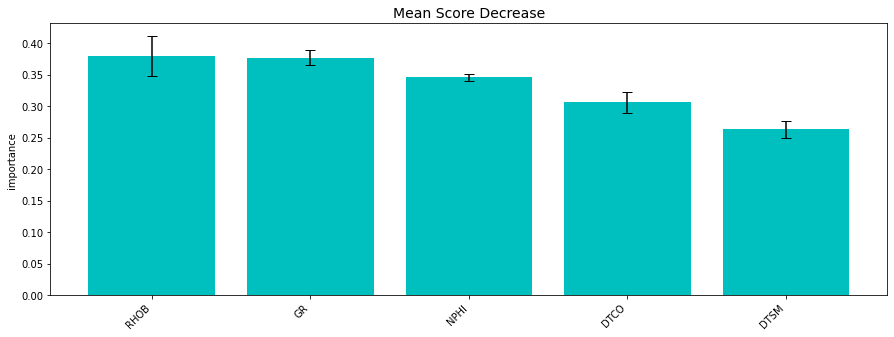

In [ ]:
df_fe = msd(X_train, y_train, model, plot = True, topk=5)

### Polynomial Features

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(scaling = 'standard', poly= 2), ['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'])            
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = GridSearchCV(pipeline, gsp.knn_poly_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 502 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1017 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 1652 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2693 out of 2700 | elapsed:  2.5min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:  2.5min finished



{'algo__n_neighbors': 3, 'algo__p': 1, 'algo__weights': 'uniform', 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
0.9250954198473282 0.8683225366518922 0.8676307007786429


## Fine-Tuning

In [ ]:
preprocessor = ColumnTransformer([
                                  ('numeric', num_pipe(scaling = 'standard', poly= 2), ['GR', 'NPHI', 'RHOB', 'DTCO', 'DTSM'])            
])

pipeline = Pipeline([
                     ('prep', preprocessor),
                     ('algo', KNeighborsClassifier())
])

model = RandomizedSearchCV(pipeline, rsp.knn_poly_params, cv= 5, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

print('')                      
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    5.5s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.9s finished



{'algo__n_neighbors': 11, 'algo__p': 1.4263810507911932, 'algo__weights': 'distance', 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': False}
0.9990458015267175 0.8626127969087396 0.8731924360400445


## Prediction

### Predict Training Data

In [ ]:
df['Facies_pred'] = model.predict(X)

df.head()

,Depth,Well,Formation,GR,NPHI,RHOB,DTCO,DTSM,Facies,Facies_pred
0,4600.0,P-2,Jamieson Fm,66.4510,13.8882,2.5715,81.8708,NaN,4,4
1,4600.5,P-2,Jamieson Fm,54.4524,12.1851,2.5604,78.5466,NaN,4,4
2,4601.0,P-2,Jamieson Fm,51.3234,12.0860,2.5458,81.6343,NaN,4,4
3,4601.5,P-2,Jamieson Fm,49.2121,11.5609,2.5479,78.2709,NaN,4,4
4,4602.0,P-2,Jamieson Fm,68.4992,15.9469,2.5307,79.5989,NaN,4,4


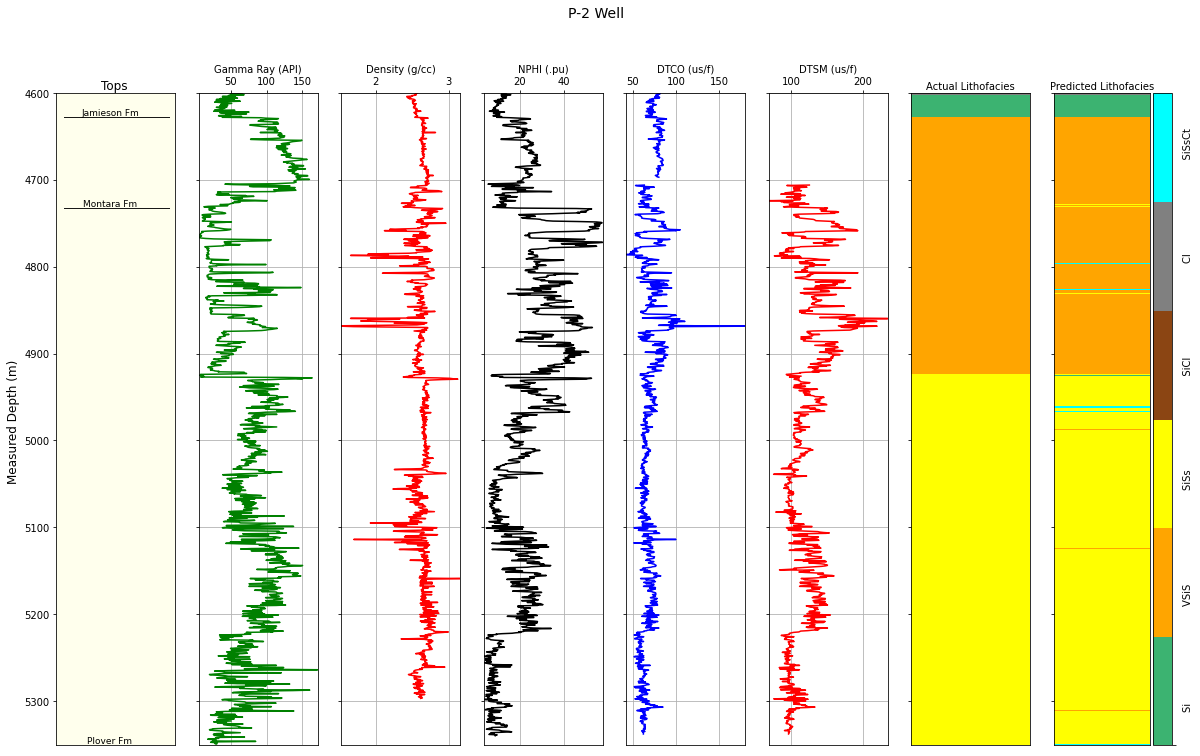

In [ ]:
lithoplot_val(df, 'P-2')

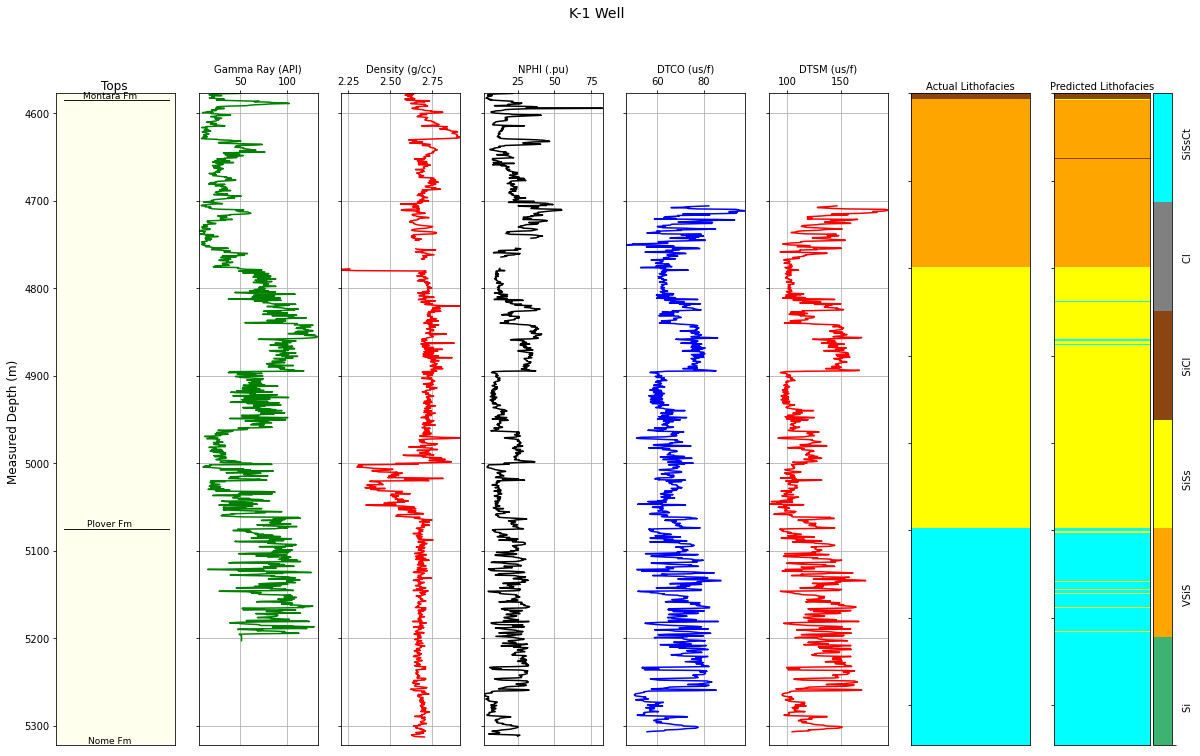

In [ ]:
lithoplot_val(df, 'K-1')

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       1.00      1.00      1.00       779
           2       1.00      1.00      1.00      1161
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00         6
           5       0.99      1.00      1.00       396

    accuracy                           1.00      2396
   macro avg       1.00      1.00      1.00      2396
weighted avg       1.00      1.00      1.00      2396


Test report
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       0.95      0.89      0.92       195
           2       0.91      0.91      0.91       291
           3       0.75      1.00      0.86         3
           4       1.00      1.00      1.00         1
           5       0.80      0.86      0.83        99

    accuracy                           0.90       5

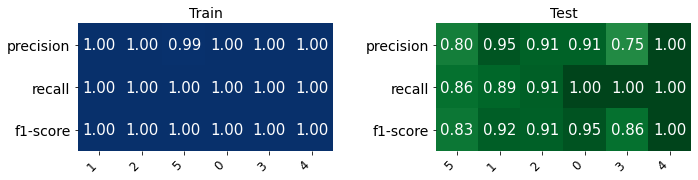

In [ ]:
plot_classification_report(X_train, y_train, X_test, y_test, model)

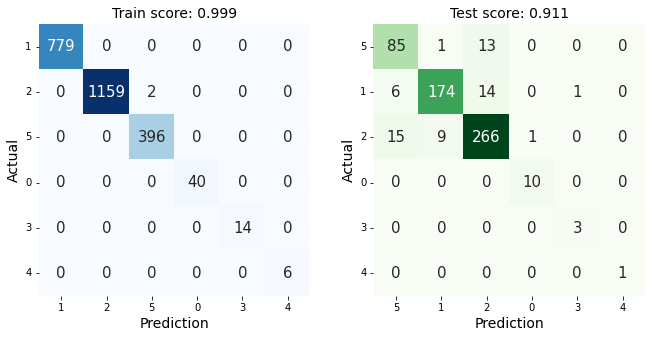

In [ ]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

### Predict Testing Data

In [ ]:
df_test = pd.read_csv('boreas.csv', index_col= 0)

df_test = df_test.replace([-999.25], np.nan)

df_test = df_test.replace([df_test['GR'].nlargest(3)], np.nan)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,2
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,1
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,1
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,3
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,3


In [ ]:
df_test.GR.nlargest(5)

652    142.8180
629    140.7753
571    133.3387
559    126.6042
651    125.3085
Name: GR, dtype: float64

In [ ]:
df_test.columns

Index(['Depth', 'Well', 'Formation', 'GR', 'RS', 'RD', 'NPHI', 'RHOB', 'DTCO',
       'DTSM', 'Ef_pred'],
      dtype='object')

In [ ]:
X_test = pd.DataFrame(df_test.drop(columns= ['Depth', 'Well', 'Formation', 'RS', 'RD', 'Ef_pred']))

X_test.head()

,GR,NPHI,RHOB,DTCO,DTSM
0,55.3259,12.04,2.6282,87.4786,NaN
1,61.7744,18.93,2.6688,93.8623,NaN
2,60.9437,20.12,2.6014,78.9452,NaN
3,67.9765,20.01,2.6130,64.5839,NaN
4,86.1773,21.62,2.6041,69.4141,NaN


In [ ]:
df_test['Facies_pred'] = model.predict(X_test)

df_test.head()

,Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred,Facies_pred
0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4170,12.04,2.6282,87.4786,NaN,2,4
1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,NaN,1,2
2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,NaN,1,2
3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.6130,64.5839,NaN,3,5
4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.0360,21.62,2.6041,69.4141,NaN,3,1


In [ ]:
df_test.to_csv()

',Depth,Well,Formation,GR,RS,RD,NPHI,RHOB,DTCO,DTSM,Ef_pred,Facies_pred\n0,4610.0,B-1,Echuca Shoals Fm,55.3259,1.4348,1.4169999999999998,12.04,2.6282,87.4786,,2,4\n1,4610.5,B-1,Echuca Shoals Fm,61.7744,1.1341,1.0694,18.93,2.6688,93.8623,,1,2\n2,4611.0,B-1,Echuca Shoals Fm,60.9437,1.1748,1.1022,20.12,2.6014,78.9452,,1,2\n3,4611.5,B-1,Echuca Shoals Fm,67.9765,1.3287,1.2345,20.01,2.613,64.5839,,3,5\n4,4612.0,B-1,Echuca Shoals Fm,86.1773,1.0648,1.036,21.62,2.6041,69.4141,,3,1\n5,4612.5,B-1,Echuca Shoals Fm,80.2059,1.3382,1.3263,21.89,2.6021,73.5985,,1,1\n6,4613.0,B-1,Echuca Shoals Fm,74.5949,1.6413,1.5482,21.34,2.6164,69.8498,,3,5\n7,4613.5,B-1,Echuca Shoals Fm,78.5921,1.3767,1.352,21.31,2.6413,91.6138,,1,1\n8,4614.0,B-1,Echuca Shoals Fm,83.1176,1.503,1.4596,20.82,2.6017,85.3235,,1,1\n9,4614.5,B-1,Echuca Shoals Fm,51.7665,1.3676,1.3686,20.89,2.5649,88.2898,,1,4\n10,4615.0,B-1,Echuca Shoals Fm,41.7301,3.7995,3.6336,17.08,2.6257,87.7482,,2,4\n11,4615.5,B-1,Echuca Shoals Fm,34.8966,7.9456,7.6

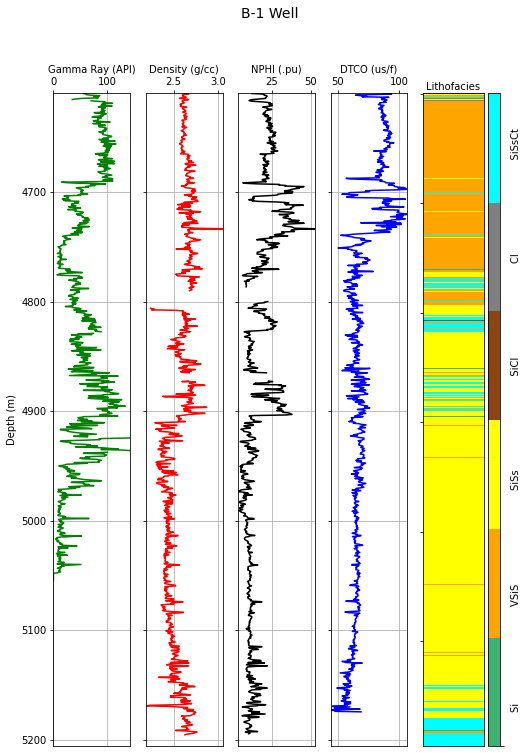

In [ ]:
lithoplot_test(df_test, 'B-1')

## Save ML Model

In [ ]:
save_model(model.best_estimator_, "__________.pkl")

Model is pickled as model/__________.pkl
